## 텍스트 마이닝

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
import mglearn
warnings.filterwarnings(action='ignore')

# 
### 텍스트 데이터 load

In [3]:
import os
os.getcwd()

'/content'

In [10]:
!rm -r /content/aclImdb/train/unsup

In [11]:
from sklearn.datasets import load_files

In [223]:
review_train = load_files('/content/aclImdb/train/')

In [224]:
text_train, y_train = review_train.data, review_train.target

In [225]:
len(text_train), y_train.shape

(25000, (25000,))

In [226]:
review_test = load_files('/content/aclImdb/test/')

In [227]:
text_test, y_test = review_test.data, review_test.target

In [228]:
len(text_test), y_test.shape

(25000, (25000,))

In [229]:
np.bincount(y_train), np.bincount(y_test)

(array([12500, 12500]), array([12500, 12500]))

# 
- **띄어쓰기를 의미하는 \<br/>을 제거**

In [22]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [23]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [24]:
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]


<br/>
<br/>
<br/>



### 텍스트 데이터를 BOW로 표현
- BOW : Bag of Words
- 장, 문단, 문장, 서식 같은 입력 텍스트의 구조 대부분을 잃고, 각 단어가 말뭉치에 있는 텍스트에 얼마나 많이 나타나는지만 헤아림
- **구조와 상관 없이, 단어의 출현 횟수만 count**

<br/>

1. **토큰화 : 각 문서를 문서에 포함된 단어(토큰)으로 나눔 (공백 혹은 구두점 기준)**
2. **어휘 사전 구축 : 모든 문서에 나타난 모든 단어의 어휘를 모으고, 번호를 매김**
3. **희소 행렬 인코딩 : 어휘 사전의 단어가 문서마다 몇 번이나 나타나는지 파악**

- **출력은 각 문서에서 나타난 단어의 횟수가 담긴 하나의 벡터**
- **사전에 있는 각 단어가 문서마다 얼마나 자주 나타나는지 파악** => **전체 데이터셋에서 고유한 각 단어를 특성으로 가짐**
- **원본 문자열에 있는 단어의 순서는 BOW 특성 표현에서 완전히 무시**

<br/>
<br/>

### ```sklearn.feature_extraction.text.CountVectorizer(min_df, max_df, stop_words, ngram_range, ...)```
- ```min_df``` : 토큰이 나타날 최소 문서 개수 지정 (자주 나타나지 않는 단어 제거)
- ```max_df``` : 토큰이 나타날 최대 문서 개수 지정 (자주 나타나는 단어 제거)
- ```stop_words``` : 내장된 불용어 사용 ('english')

In [25]:
bards_words = ["The fool doth think he is wise,",
               "but the wise man knows himself to be a fool"]

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
vect = CountVectorizer().fit(bards_words)

In [28]:
vect.get_feature_names_out()

array(['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man',
       'the', 'think', 'to', 'wise'], dtype=object)

In [29]:
vect.vocabulary_, len(vect.vocabulary_)

({'the': 9,
  'fool': 3,
  'doth': 2,
  'think': 10,
  'he': 4,
  'is': 6,
  'wise': 12,
  'but': 1,
  'man': 8,
  'knows': 7,
  'himself': 5,
  'to': 11,
  'be': 0},
 13)

#### BOW 표현을 만들려면 ```.transform()```을 적용
- SciPy 희소 행렬로 저장

In [30]:
bag_of_words = vect.transform(bards_words)

In [31]:
repr(bag_of_words)

"<2x13 sparse matrix of type '<class 'numpy.int64'>'\n\twith 16 stored elements in Compressed Sparse Row format>"

In [32]:
bag_of_words.toarray(), bag_of_words.shape

(array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]]), (2, 13))

<br/>
<br/>

### 영화 리뷰 BOW

In [33]:
vect = CountVectorizer().fit(text_train)
x_train = vect.transform(text_train)

In [34]:
feature_names = vect.get_feature_names_out()

In [35]:
feature_names[:20], feature_names.shape, len(vect.vocabulary_)

(array(['00', '000', '0000000000001', '00001', '00015', '000s', '001',
        '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am',
        '00pm', '00s', '01', '01pm', '02'], dtype=object), (74849,), 74849)

<br/>

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [37]:
scores = cross_val_score(LogisticRegression(max_iter=1000), 
                         x_train, y_train)

In [38]:
np.mean(scores)

0.88128

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [41]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid). \
    fit(x_train, y_train)
grid.best_score_, grid.best_params_, grid.score(x_train, y_train)

(0.8881599999999998, {'C': 0.1}, 0.97484)

In [42]:
x_test = vect.transform(text_test)
grid.score(x_test, y_test)

0.87888

<br/>
<br/>
 
#### ```CountVectorizer()```의 min_df를 조정하여, 토큰이 나타날 최소 문서 개수 지정
- **의미 없는 특성 (숫자 등)을 감소**

In [43]:
vect = CountVectorizer(min_df=5).fit(text_train)
x_train = vect.transform(text_train)

In [44]:
feature_names = vect.get_feature_names_out()

In [45]:
feature_names[:20], feature_names.shape, len(vect.vocabulary_)

(array(['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06',
        '07', '08', '09', '10', '100', '1000', '100th', '101', '102',
        '103'], dtype=object), (27271,), 27271)

In [46]:
x_train.toarray().shape

(25000, 27271)

In [47]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid). \
    fit(x_train, y_train)
grid.best_score_, grid.best_params_, grid.score(x_train, y_train)

(0.8880800000000001, {'C': 0.1}, 0.97124)

<br/> 
<br/>
<br/>
### 불용어
### ```sklearn.feature_extraction.text.ENGLISH_STOP_WORDS```

In [48]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [49]:
len(ENGLISH_STOP_WORDS)

318

In [50]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
x_train = vect.transform(text_train)

In [51]:
feature_names = vect.get_feature_names_out()

In [52]:
feature_names[:20], feature_names.shape, len(vect.vocabulary_)

(array(['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06',
        '07', '08', '09', '10', '100', '1000', '100th', '101', '102',
        '103'], dtype=object), (26966,), 26966)

In [53]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid). \
    fit(x_train, y_train)
grid.best_score_, grid.best_params_, grid.score(x_train, y_train)

(0.8828400000000001, {'C': 0.1}, 0.96836)

<br/>
<br/>

### tf-idf (데이터 스케일 변경)
- **다른 문서보다 특정 문서에 자주 나타나는 단어에 높은 가중치 부여**

$tf-idf(w, d) = tf(log({{N+1} \over {N_w + 1}})+1)
$

- $N$ : 훈련 데이터에 있는 문서의 개수
- $N_w$ : 단어 $w$가 나타난 훈련 데이터 문서의 개수
- $tf$ (단어 빈도수) : 단어 $w$가 대상 문서 $d$(변환 또는 인코딩 하려는 문서)에 나타난 횟수

<br/>

### ```sklearn.feature_extraction.text.TfidfVectorizer(min_df, max_df, stop_words, ngram_range,  ...)```
- ```CountVectorizer```가 만든 희소 행렬을 입력받아 변환
- 텍스트 데이터를 입력받아 BOW 특성 추출과, tf-idf 변환 수행
- tf-idf 계산을 한 후에, L2정규화 수행 (유클리디안 노름이 1이 되도록 각 문서 벡터의 스케일 변환)
- 스케일이 변환된 벡터는 문서의 길이 (단어의 수)에 영향을 받지 않음

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [55]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

In [56]:
grid = GridSearchCV(pipe, param_grid).fit(text_train, y_train)

In [57]:
grid.best_score_, grid.score(text_train, y_train), grid.score(text_test, y_test)

(0.8918800000000001, 0.98284, 0.88096)

<br/>

#### tf-idf는 비지도 학습으로써, 반응변수의 레이블과 관계있는 것은 아님
- 전체 문서에 걸쳐 많이 나타나면 idf값이 1에 가깝게 됨
- 조금씩 사용되거나, 매우 긴 문서에서만 사용되면, tf-idf값이 작아짐

In [58]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
x_train = vectorizer.transform(text_train)

In [59]:
max_value = x_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

In [60]:
feature_names = np.array(vectorizer.get_feature_names_out())

<br/>

- **tf-idf가 가장 높은 10개, 가장 낮은 10개 단어**

In [61]:
feature_names[sorted_by_tfidf[:10]], feature_names[sorted_by_tfidf[-10:]]

(array(['suplexes', 'gauche', 'hypocrites', 'oncoming', 'songwriting',
        'galadriel', 'emerald', 'mclaughlin', 'sylvain', 'oversee'],
       dtype=object),
 array(['xica', 'darkman', 'woo', 'casper', 'doodlebops', 'smallville',
        'wei', 'scanners', 'steve', 'pokemon'], dtype=object))

- **idf가 가장 높은 10개, 가장 낮은 10개 단어**

In [62]:
sorted_by_idf = np.argsort(vectorizer.idf_)
feature_names[sorted_by_idf[:10]], feature_names[sorted_by_idf[-10:]]

(array(['the', 'and', 'of', 'to', 'this', 'is', 'it', 'in', 'that', 'but'],
       dtype=object),
 array(['tepper', 'prc', 'greenstreet', 'callaghan', 'caligula',
        'pratfall', 'prankster', 'prakash', 'grayce', 'émigré'],
       dtype=object))

<br/>
<br/>

### 모형 계수
- 좌측의 음수 계수는 모형에서 부정적인 리뷰를 의미하는 단어
- 우측의 양수 계수는 긍적적인 리뷰의 단어에 해당

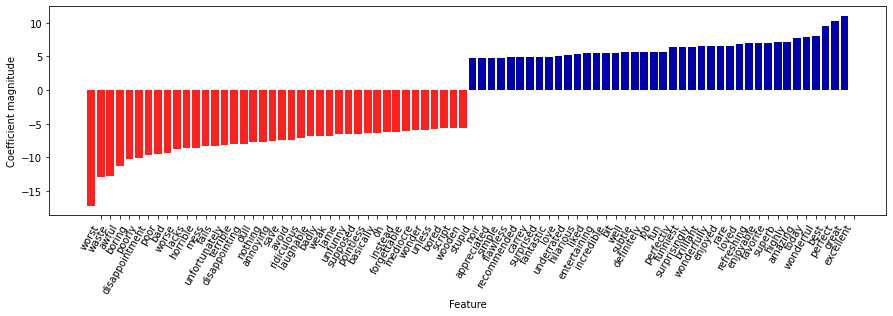

In [63]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_[0],
    feature_names, n_top_features=40
)

<br/>
<br/>
<br/>

### N-gram (여러 단어로 만든 BOW)
- **BOW의 표현 방식은 단어의 순서가 완전히 무시됨**
- 따라서 문맥을 고려하는 주변의 토큰을 포함하여 BOW화
- gram의 수가 너무 많아지면, 구체적인 특성이 많아 지기 때문에, 과대적합 가능성 증가

<br/>

#### ```CountVectorizer()```의 ngram_range를 조정하여, 토큰이 나타날 최소 문서 개수 지정


In [64]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)

In [65]:
cv.vocabulary_, cv.get_feature_names_out()

({'the fool': 9,
  'fool doth': 3,
  'doth think': 2,
  'think he': 11,
  'he is': 4,
  'is wise': 6,
  'but the': 1,
  'the wise': 10,
  'wise man': 13,
  'man knows': 8,
  'knows himself': 7,
  'himself to': 5,
  'to be': 12,
  'be fool': 0},
 array(['be fool', 'but the', 'doth think', 'fool doth', 'he is',
        'himself to', 'is wise', 'knows himself', 'man knows', 'the fool',
        'the wise', 'think he', 'to be', 'wise man'], dtype=object))

<br/>

In [66]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000))

In [67]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

In [68]:
grid = GridSearchCV(pipe, param_grid).fit(text_train, y_train)

In [72]:
grid.best_params_, grid.best_score_

({'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)},
 0.9064400000000001)

In [73]:
grid.score(text_train, y_train), grid.score(text_test, y_test)

(1.0, 0.90208)

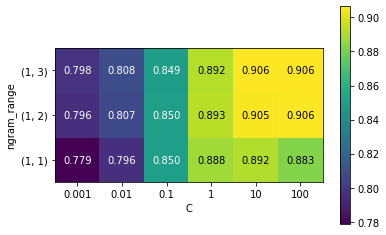

In [74]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel ='C', ylabel='ngram_range', cmap='viridis', fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])

plt.colorbar(heatmap)
plt.show()

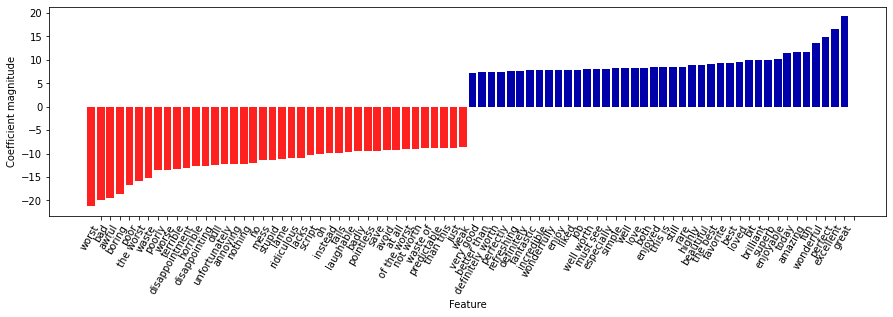

In [76]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

<br/>
<br/>
<br/>

### 고급 토큰화, 어간 추출, 표제어 추출
- **어간 추출 (Stemming)** : 일일이 어미를 찾아 제외하는 규칙 기방 방식 (drawback, drawers, drawings 등)
- **표제어 추출 (Jemmatization)** : 알려진 단어의 형태 사전을 사용하고, 문장에서 단어의 역할을 고려하는 처리방식 
- **표제어 추출과 어간 추출은 단어의 일반 형태를 추출하는 정규화의 한 형태**

In [77]:
import spacy
import nltk

In [78]:
spacy.__version__, nltk.__version__

('3.4.1', '3.7')

- **spacy의 영어 모델 로드 : 표제어 추출**
- **nltk의 PorterStemmer 객체 생성 : 어간 추출** 

<br/>

### ```spacy.load()``` : spacy 모델 로드

In [83]:
en_nlp = spacy.load('en_core_web_sm')
stemmer = nltk.stem.PorterStemmer()

<br/>

### ```en_nlp()``` : spacy로 문서 토큰화
### ```stemmer객체.stem()``` : 어간 추출


In [85]:
def compare_normalization(doc):
    # 문서 토큰화
    doc_spacy = en_nlp(doc)
    
    # 표제어 출력
    print("Jemmatization")
    print([token.lemma_ for token in doc_spacy])
    
    # 토큰 출력
    print("Stemming")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

- **표제어 추출 vs 어간 추출 비교**

In [87]:
compare_normalization(u"Our meeting today was worse than yesterday, I'm scared of meeting the clients tomorrow.")

Jemmatization
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


- **머신러닝을 위해 토큰 정규화를 할 때는, 어간 추출보다 표제어 추출이 좋은 결과를 낸다고 알려짐**
- **데이터셋이 작을 대도 표제어 추출을 통해 성능 향상 가능**
- **표제어 추출과 어간 추출은 모형을 더 낫게 (간단하게) 만들어 주기 때문에, 마지막 성능까지 쥐어 짜내야 할 때 시도 가능**

<br/>
<br/>
<br/>

### LDA
- 잠재 디레클레 할당(LDA)은 대표적인 토픽 모델링 알고리즘 중 하나

- 잠재 디레클레 할당 방법

  - 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  - 모든 단어들을 토픽 중 하나에 할당
  - 모든 문서의 모든 단어에 대해 단어 $w$가 가정에 의거, $p(w|t)$ $p(w|t)$ 에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미

- $p(t|d)$ : 문서 d의 단어들 중 토픽 t에 해당하는 비율
- 해당 문서의 자주 등장하는 다른 단어의 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미

- $p(w|t)$ : 단어 $w$를 가지고 있는 모든 문서들 중 토픽 t가 할당된 비율

- 다른 문서에서 단어 w에 많이 할당된 토픽이 해당 단어의 토픽이 될 가능성이 높음을 의미

<br/>

### ```sklearn.decomposition.LatentDirichletAllocation(n_components, learning_method, max_iter, ...)```

- ```n_components``` : 축소할 성분 수
- ```learning_method``` : 학습 방법 ("online" / "batch")

In [230]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [231]:
from sklearn.decomposition import LatentDirichletAllocation

In [233]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch',
                                max_iter=25, random_state=0)

In [234]:
document_topics = lda.fit_transform(X)

<br/>

#### ```.components_``` 각 토픽의 중요도
- **n_topics $\times$ n_words**

In [236]:
lda.components_.shape

(10, 10000)

- 토픽 별 특성을 오름차순으로 정렬

In [237]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names_out())

In [239]:
sorting.shape

(10, 10000)

In [240]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
director      show          book          family        funny         
work          series        original      young         comedy        
performance   war           10            father        cast          
actors        episode       now           us            role          
cast          tv            again         woman         humor         
screen        years         world         own           fun           
performances  american      saw           world         jokes         
role          episodes      read          real          actors        
both          world         didn          mother        performance   
quite         shows         am            between       always        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

<br/>
<br/>


In [241]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [242]:
import random
topics = np.array(random.sample(range(100), 10))

In [243]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names_out())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 63      topic 61      topic 9       topic 49      topic 82      
--------      --------      --------      --------      --------      
drugs         war           music         dvd           art           
drug          men           michael       release       beautiful     
freeman       women         band          released      sexual        
money         american      voice         available     woman         
disturbing    country       jackson       video         cinema        
real          during        video         vhs           each          
experiment    world         rock          extras        young         
ll            americans     price         bought        sex           
morgan        soldiers      fan           find          work          
abuse         soldier       clips         commentary    kind          
rat           military      soundtrack    collection    between       
rats          army          cd            tape          feel          
spacey

<br/>

#### 9번쨰 토픽은 음악(music)과 관련된 토픽임을 알 수 있음

In [247]:
music = np.argsort(document_topics100[:, 9])[::-1]

In [261]:
for i in music[:3]:
  print(text_train[i])

b'...said a couple exiting the movie theater just as I was entering to watch this. Hmm, not a good sign, but who knows? Different strokes for different folks, after all. Well, nope. They were being kind. Godard has released work that is passionate (Contempt), entertaining (Band of Outsiders), sometimes both (My Life to Live). This is just dull intellectualism, that grates on the nerves pretty quickly. During my showing, literally half of the audience had walked out by the end of the film. If only I had been so wise.'
b"I like a lot of the actors/actresses involved in this project so being insulted by the movie felt even worse than if they used a unknowns .The main problem was this movie was clearly just a concept created to appeal to baby boomers .In 20 or 30 years Nbc will probably do a movie just like this about the early 90's . I can see it now a black family where the kids are involved with the la riot's and the white family has the kids rebel and listen to grunge rock music .The s

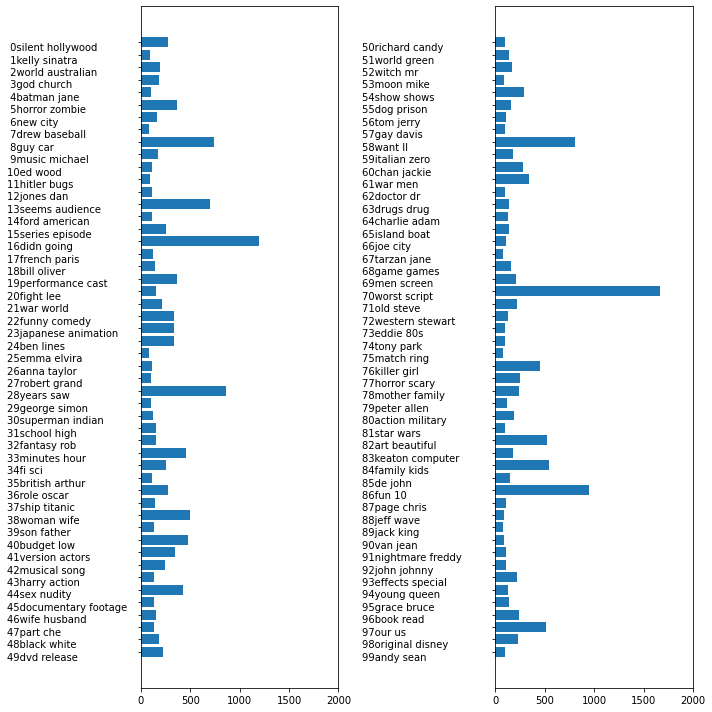

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2}".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

for col in [0, 1]:
  start = col * 50
  end = (col + 1) * 50
  ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
  ax[col].set_yticks(np.arange(50))
  ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
  ax[col].invert_yaxis()
  ax[col].set_xlim(0, 2000)
  yax = ax[col].get_yaxis()
  yax.set_tick_params(pad=130)

plt.tight_layout()
plt.show()